In [2]:
!pip install pandas==2.2.3 tensorflow==2.19.0 scikit-learn==1.5.2 imbalanced-learn==0.13.0 scikeras==0.13.0

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, concatenate
from tensorflow.keras.models import Model

In [4]:
df = pd.read_csv('actu_finance.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,ORA_ACTU,GLE_ACTU,ALO_ACTU,KER_ACTU,CAP_ACTU,AIR_ACTU,CS_ACTU,BNP_ACTU,ORA_RDMT_5,GLE_RDMT_5,ALO_RDMT_5,KER_RDMT_5,CAP_RDMT_5,AIR_RDMT_5,CS_RDMT_5,BNP_RDMT_5
2017-01-02,NR,NR,NR,Nouveau record absolu à 216.3E (CF),NR,NR,Cession de Bluefin finalisée au Royaume-Uni (CF),Un nouveau responsable pour l'Allemagne (CF) |...,0.014413,-0.014924,0.001136,-0.001385,0.001364,0.039159,0.019677,0.013919
2017-01-04,Partenariat avec PSA et Ericsson (CF),NR,NR,NR,NR,NR,NR,Real Estate participe au CES (CF) | Franchit l...,-0.003740,-0.038147,0.010015,0.055372,-0.000997,0.032492,-0.015173,-0.034713
2017-01-05,NR,"Pic sans lendemain vers 49,375E (CF)",NR,NR,BlackRock dépasse les 5% (CF),Bien orienté grâce à des relèvements de broker...,NR,Nomination chez Real Estate (CF),-0.001014,-0.025902,-0.000381,0.080391,-0.004349,0.001393,-0.031775,-0.026840
2017-01-09,NR,Pullback jusque sur 46E (CF) | Nomination en I...,Contrat au Mexique (CF),NR,BlackRock repasse au-dessus de 5% (CF) | Black...,NR,NR,NR,0.009134,0.001190,-0.001892,0.045759,-0.017209,-0.001532,-0.035141,0.000327
2017-01-11,NR,NR,Retenu avec Bombardier pour le réseau francili...,"Nouveau 'gap' haussier, au dessus des 218E (CF...",BlackRock passe sous les 5% (CF),Iran Air réceptionne son premier A321 (CF) | G...,NR,NR,0.021843,-0.018968,-0.031244,0.015022,-0.032327,-0.009471,-0.048891,-0.015341


Le jeu de données contient des informations journalières de 2017 à 2023 sur 8 entreprises du CAC 40. Pour chaque jour, il indique s’il y a eu une actualité concernant chaque entreprise (colonne `X_ACTU`) ou non (valeur "NR"). Lorsqu’une actualité est présente, elle est décrite sous forme de titre. En parallèle, chaque ligne fournit le rendement boursier à 5 jours ouvrés pour chaque entreprise (colonne `X_RDMT_5`). Ainsi, les données permettent d’étudier l’impact potentiel d’une actualité sur le rendement futur d’un actif, en combinant texte (actualités) et données financières (rendements).

In [5]:

print("Valeurs manquantes par colonne :")
df.isnull().sum()


Valeurs manquantes par colonne :


,0
ORA_ACTU,0
GLE_ACTU,0
ALO_ACTU,0
KER_ACTU,0
CAP_ACTU,0
AIR_ACTU,0
CS_ACTU,0
BNP_ACTU,0
ORA_RDMT_5,0
GLE_RDMT_5,0


In [6]:

print("Résumé statistique :")
display(df.describe(exclude=[object]))
df.describe(include=[object])


Résumé statistique :


,ORA_RDMT_5,GLE_RDMT_5,ALO_RDMT_5,KER_RDMT_5,CAP_RDMT_5,AIR_RDMT_5,CS_RDMT_5,BNP_RDMT_5
count,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000
mean,-0.000773,-0.000820,-0.000899,0.002520,0.003427,0.003318,0.001266,0.000680
std,0.027210,0.054832,0.049394,0.044154,0.042971,0.051081,0.039878,0.046380
min,-0.221232,-0.317709,-0.412320,-0.233300,-0.297323,-0.427480,-0.281625,-0.259675
25%,-0.014176,-0.025203,-0.022386,-0.022415,-0.016387,-0.018847,-0.016342,-0.021449
50%,-0.000208,0.001178,0.000956,0.005328,0.004030,0.003510,0.002948,0.001196
75%,0.014105,0.028049,0.024353,0.026196,0.024732,0.024978,0.020554,0.025079
max,0.190172,0.281014,0.222395,0.320190,0.338290,0.428219,0.309108,0.277626


,ORA_ACTU,GLE_ACTU,ALO_ACTU,KER_ACTU,CAP_ACTU,AIR_ACTU,CS_ACTU,BNP_ACTU
count,1674,1674,1674,1674,1674,1674,1674,1674
unique,572,504,632,376,513,1004,409,459
top,NR,NR,NR,NR,NR,NR,NR,NR
freq,1087,1164,1039,1297,1138,670,1234,1207


In [7]:
assets = [x.split("_")[0] for x in df.columns[df.columns.str.endswith('ACTU')]]
assets

['ORA', 'GLE', 'ALO', 'KER', 'CAP', 'AIR', 'CS', 'BNP']

In [8]:
def get_news_statistics(asset):
    news_col = asset + "_ACTU"
    rdmt_col = asset + "_RDMT_5"
    df_news = df[df[news_col] != "NR"]

    count_news = df_news.shape[0]
    total_rows = df.shape[0]
    perc_news = count_news / total_rows * 100

    stats_rdmt = df_news[rdmt_col].describe()
    desc_stats = {
        "Count_News": count_news,
        "Total_Rows": total_rows,
        "Percent_News": perc_news,
        "Returns_Stats": stats_rdmt
    }

    return desc_stats

desc_stats = {}
for asset in assets:

    desc_stats[asset] = get_news_statistics(asset)
    print(f"Actif : {asset}")
    print(f"  Nombre d'actualités (≠ 'NR') : {desc_stats[asset]['Count_News']} sur {desc_stats[asset]['Total_Rows']} lignes ({desc_stats[asset]['Percent_News']:.2f}%)")
    print("  Statistiques descriptives du rendement (quand actualité présente) :")
    print(desc_stats[asset]['Returns_Stats'])
    print("-" * 50)


Actif : ORA
  Nombre d'actualités (≠ 'NR') : 587 sur 1674 lignes (35.07%)
  Statistiques descriptives du rendement (quand actualité présente) :
count    587.000000
mean       0.000341
std        0.025138
min       -0.089933
25%       -0.014465
50%        0.000613
75%        0.014698
max        0.158930
Name: ORA_RDMT_5, dtype: float64
--------------------------------------------------
Actif : GLE
  Nombre d'actualités (≠ 'NR') : 510 sur 1674 lignes (30.47%)
  Statistiques descriptives du rendement (quand actualité présente) :
count    510.000000
mean      -0.003006
std        0.054395
min       -0.245283
25%       -0.027137
50%       -0.000327
75%        0.025619
max        0.281014
Name: GLE_RDMT_5, dtype: float64
--------------------------------------------------
Actif : ALO
  Nombre d'actualités (≠ 'NR') : 635 sur 1674 lignes (37.93%)
  Statistiques descriptives du rendement (quand actualité présente) :
count    635.000000
mean      -0.000393
std        0.056169
min       -0.412168


In [9]:
for asset in assets:
    news_col = asset + "_ACTU"
    news_per_year = df[df[news_col] != "NR"][[news_col]].reset_index(names="date").groupby(pd.Grouper(key="date", freq="YE")).size() #ME for monthly
    print(f"Actualités pour {asset} par année :")
    print(news_per_year)
    print("-" * 50)

Actualités pour ORA par année :
date
2017-12-31    69
2018-12-31    78
2019-12-31    81
2020-12-31    88
2021-12-31    94
2022-12-31    93
2023-12-31    84
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour GLE par année :
date
2017-12-31    96
2018-12-31    77
2019-12-31    80
2020-12-31    63
2021-12-31    62
2022-12-31    66
2023-12-31    66
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour ALO par année :
date
2017-12-31     98
2018-12-31     84
2019-12-31     83
2020-12-31     67
2021-12-31     96
2022-12-31     92
2023-12-31    115
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour KER par année :
date
2017-12-31    50
2018-12-31    61
2019-12-31    46
2020-12-31    49
2021-12-31    47
2022-12-31    59
2023-12-31    65
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour CAP par année :
date
2017-12-31    56
201

In [10]:
df_desc_stats = pd.DataFrame(desc_stats).T.sort_values("Percent_News", ascending=False).T

In [11]:
df_desc_stats

,AIR,ALO,ORA,CAP,GLE,BNP,CS,KER
Count_News,1004,635,587,536,510,467,440,377
Total_Rows,1674,1674,1674,1674,1674,1674,1674,1674
Percent_News,59.976105,37.933094,35.065711,32.019116,30.46595,27.897252,26.284349,22.520908
Returns_Stats,count 1004.000000 mean 0.002403 std ...,count 635.000000 mean -0.000393 std ...,count 587.000000 mean 0.000341 std ...,count 536.000000 mean 0.002953 std ...,count 510.000000 mean -0.003006 std ...,count 467.000000 mean 0.004333 std ...,count 440.000000 mean 0.001598 std ...,count 377.000000 mean 0.002142 std ...


In [12]:
chosen_assets = df_desc_stats.columns[:5]

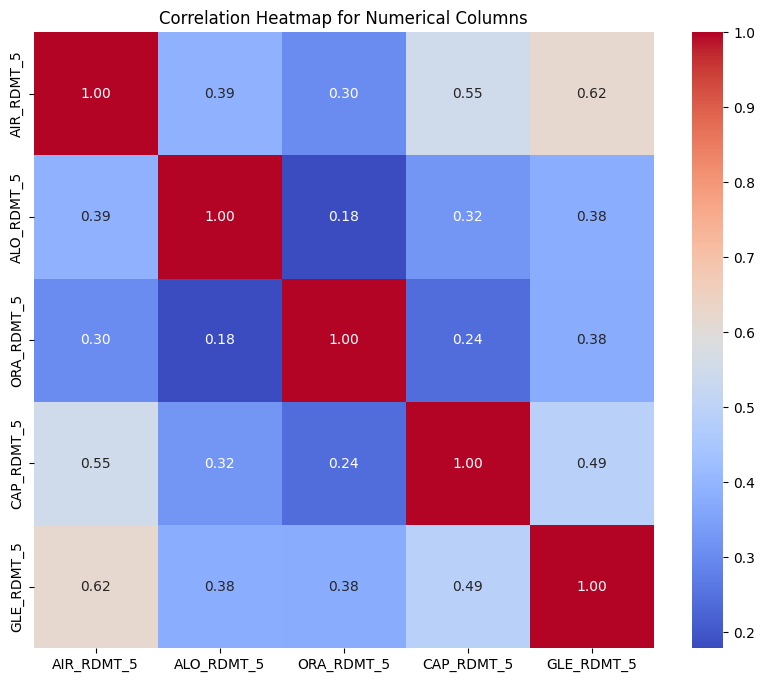

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_cols = df[[x+"_RDMT_5" for x in chosen_assets]]

# Compute the correlation matrix
corr_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap for Numerical Columns")
plt.show()

In [14]:
(df[news_col] != "NR").sum()

np.int64(467)

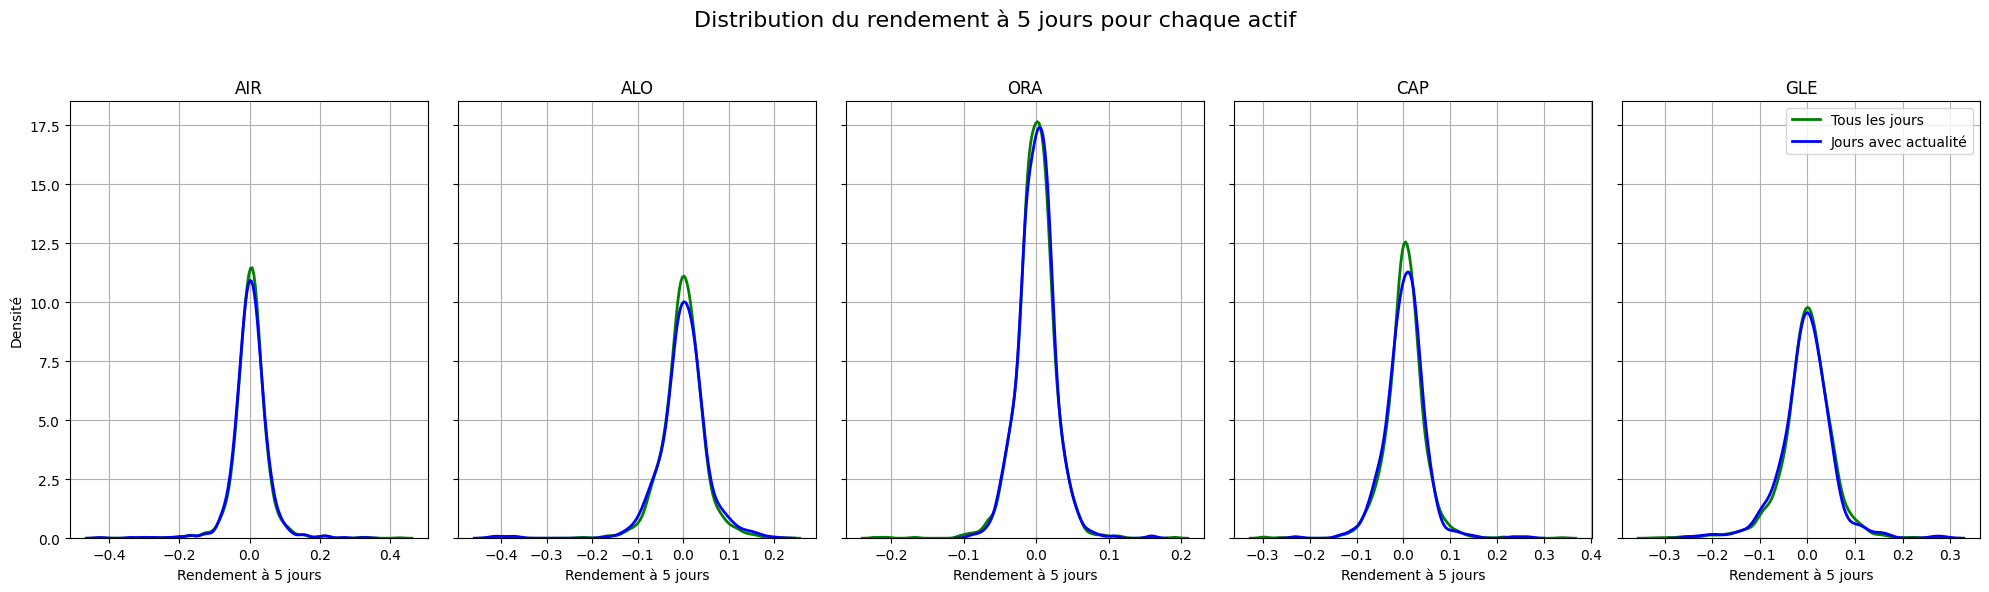

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single row of subplots
fig, axes = plt.subplots(1, len(chosen_assets), figsize=(20, 6), sharey=True)

for i, asset in enumerate(chosen_assets):
    news_col = asset + "_ACTU"
    rdmt_col = asset + "_RDMT_5"

    df_with_news = df[df[news_col] != "NR"][rdmt_col]
    df_all = df[rdmt_col]

    sns.kdeplot(df_all, label='Tous les jours', color='green', linewidth=2, ax=axes[i])
    sns.kdeplot(df_with_news, label='Jours avec actualité', color='blue', linewidth=2, ax=axes[i])
    axes[i].set_title(f"{asset}")
    axes[i].set_xlabel("Rendement à 5 jours")
    axes[i].grid(True)

axes[0].set_ylabel("Densité")
fig.suptitle("Distribution du rendement à 5 jours pour chaque actif", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
axes[-1].legend(loc='upper right')
plt.show()


<ipython-input-16-99d736942a35>:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x="Asset", y="Mean Return", hue="Type", palette="viridis", ci=None)


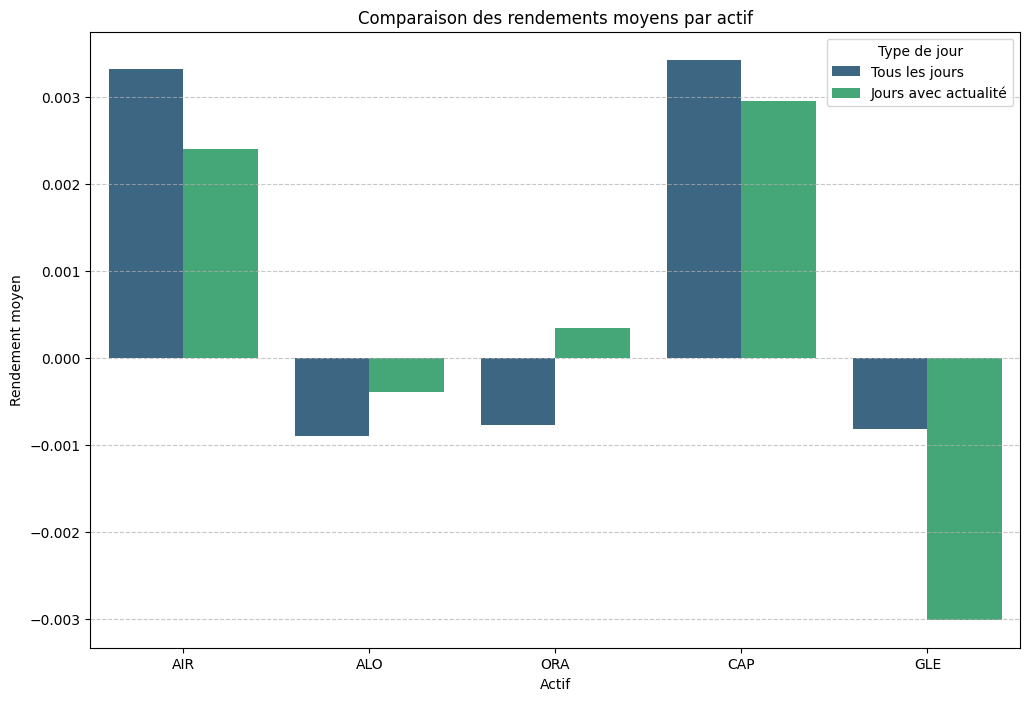

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
data = []
for asset in chosen_assets:
    news_col = asset + "_ACTU"
    rdmt_col = asset + "_RDMT_5"

    df_with_news = df[df[news_col] != "NR"][rdmt_col]
    df_all = df[rdmt_col]

    data.append({
        "Asset": asset,
        "Type": "Tous les jours",
        "Mean Return": df_all.mean(),
        "Std Return": df_all.std()
    })
    data.append({
        "Asset": asset,
        "Type": "Jours avec actualité",
        "Mean Return": df_with_news.mean(),
        "Std Return": df_with_news.std()
    })

# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame(data)

# Plot grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, x="Asset", y="Mean Return", hue="Type", palette="viridis", ci=None)
plt.title("Comparaison des rendements moyens par actif")
plt.ylabel("Rendement moyen")
plt.xlabel("Actif")
plt.legend(title="Type de jour")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [17]:
import requests
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/refs/heads/master/stopwords-fr.txt"

response = requests.get(url)
response.raise_for_status()
french_stopwords = set(response.text.splitlines())


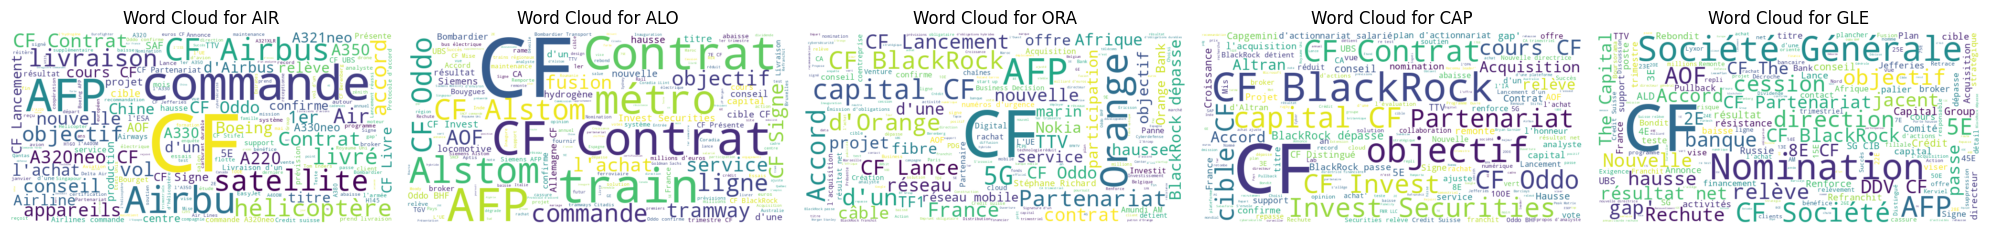

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create a word cloud for each asset's actualities
fig, axes = plt.subplots(1, len(chosen_assets), figsize=(20, 6))

for i, asset in enumerate(chosen_assets):
    news_col = asset + "_ACTU"
    text = " ".join(df[df[news_col] != "NR"][news_col].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=french_stopwords).generate(text)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"Word Cloud for {asset}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [19]:
df.columns

Index(['ORA_ACTU', 'GLE_ACTU', 'ALO_ACTU', 'KER_ACTU', 'CAP_ACTU', 'AIR_ACTU',
       'CS_ACTU', 'BNP_ACTU', 'ORA_RDMT_5', 'GLE_RDMT_5', 'ALO_RDMT_5',
       'KER_RDMT_5', 'CAP_RDMT_5', 'AIR_RDMT_5', 'CS_RDMT_5', 'BNP_RDMT_5'],
      dtype='object')

In [20]:
cols = df.columns[df.columns.isin(["GLE_RDMT_5", "BNP_RDMT_5"])]
df[cols].corr()

,GLE_RDMT_5,BNP_RDMT_5
GLE_RDMT_5,1.000000,0.893992
BNP_RDMT_5,0.893992,1.000000


Pour les actu de GLE on voir que Societe Generale est tres montione dans les actualités. ce qui peut expliquer la correlation entre les rendements de GLE et ceux de BNP.

<Axes: title={'center': 'Distribution de la cible Y'}, xlabel='Y'>

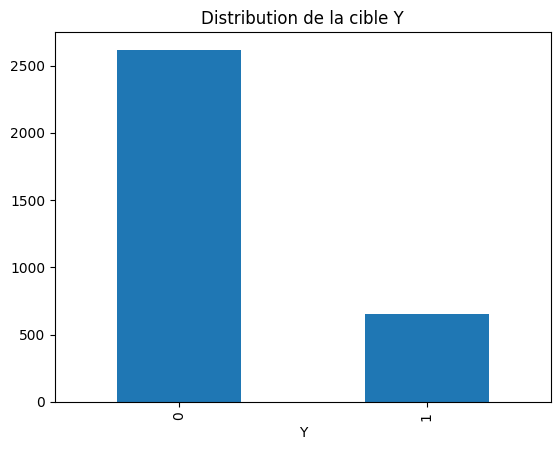

In [21]:

top_assets = chosen_assets

# Étape 2 : construire le dataset concaténé {ACTU, RDMT_5}
rows = []
for asset in top_assets:
    sub_df = df[df[f"{asset}_ACTU"] != "NR"]
    rows.append(sub_df[[f"{asset}_ACTU", f"{asset}_RDMT_5"]].rename(columns={f"{asset}_ACTU": "ACTU", f"{asset}_RDMT_5": "RDMT_5"}))

data = pd.concat(rows).reset_index()

# Création de Y à partir du quantile 80%
q80 = data["RDMT_5"].quantile(0.80)
data["Y"] = (data["RDMT_5"] > q80).astype(int)

data["Y"].value_counts().plot(kind="bar", title="Distribution de la cible Y")

---

# Modeling


# Data Loading and Preparation


In [22]:

X_text = data["ACTU"].values  # text data
y = data["Y"].values          # binary target



In [23]:
data.set_index("index")[["ACTU", "RDMT_5"]].to_csv("data.csv")


# Custom Transformer: Text Preprocessing


In [24]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    This transformer tokenizes and pads text data.
    """
    def __init__(self, num_words=5000, maxlen=30, tokenizer=None):
        self.num_words = num_words
        self.maxlen = maxlen
        if tokenizer is None:
            self.tokenizer = Tokenizer(num_words=self.num_words, lower=True)
            self._tokenizer_provided = False
        else:
            self.tokenizer = tokenizer
            self._tokenizer_provided = True

    def fit(self, X, y=None):
        # Only fit the tokenizer if it wasn't provided pre-fitted
        if not self._tokenizer_provided:
            self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        sequences = self.tokenizer.texts_to_sequences(X)
        padded = pad_sequences(sequences, maxlen=self.maxlen)
        return padded


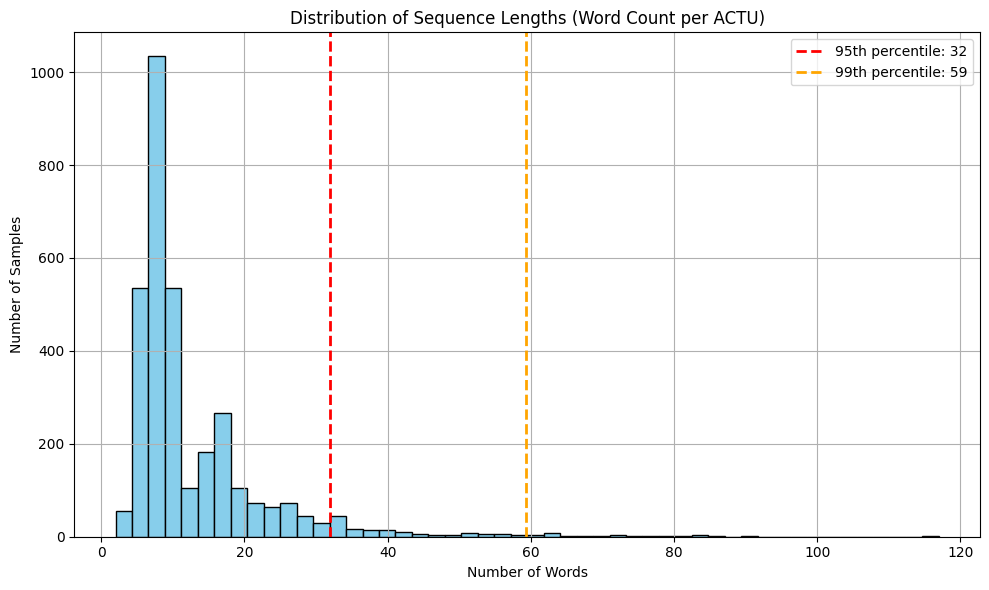

{50: np.float64(9.0),
 75: np.float64(16.0),
 90: np.float64(24.0),
 95: np.float64(32.0),
 99: np.float64(59.289999999999964)}

In [25]:
sequence_lengths = data["ACTU"].apply(lambda x: len(str(x).split()))

# Compute percentiles for insight
percents = [50, 75, 90, 95, 99]
percentiles = dict(zip(percents,np.percentile(sequence_lengths,percents )))

# Plot distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(list(percentiles.values())[3], color='red', linestyle='dashed', linewidth=2, label=f'95th percentile: {list(percentiles.values())[3]:.0f}')
plt.axvline(list(percentiles.values())[4], color='orange', linestyle='dashed', linewidth=2, label=f'99th percentile: {list(percentiles.values())[4]:.0f}')
plt.title("Distribution of Sequence Lengths (Word Count per ACTU)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();
percentiles


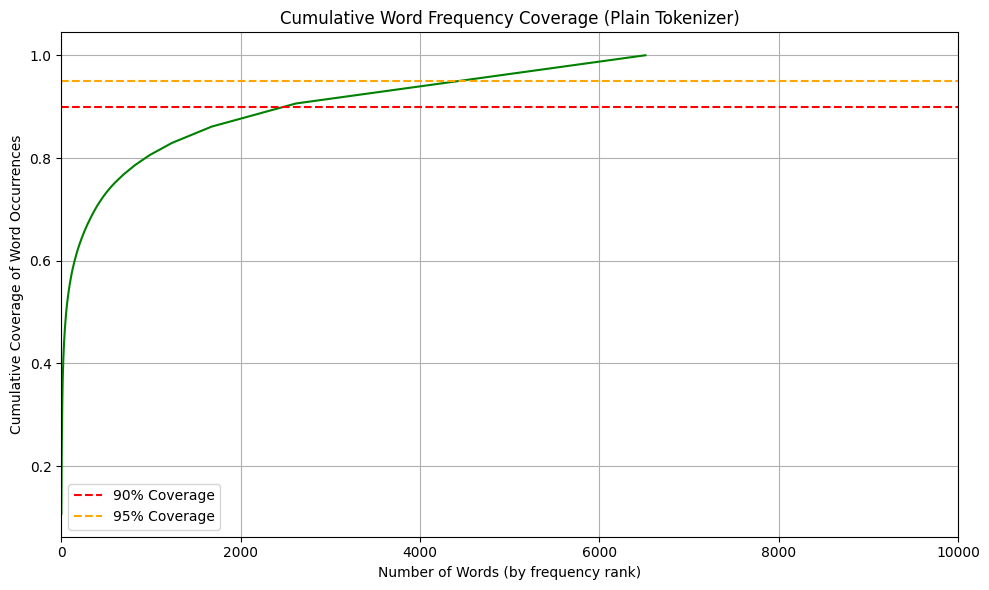

(np.int64(2485), np.int64(4438))

In [26]:
from collections import Counter

all_words = ' '.join(data['ACTU'].astype(str).str.lower()).split()
word_freq = Counter(all_words)

sorted_counts = sorted(word_freq.values(), reverse=True)
total_tokens = sum(sorted_counts)
cumulative = np.cumsum(sorted_counts) / total_tokens

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative) + 1), cumulative, color='green')
plt.xlabel("Number of Words (by frequency rank)")
plt.ylabel("Cumulative Coverage of Word Occurrences")
plt.title("Cumulative Word Frequency Coverage (Plain Tokenizer)")
plt.grid(True)
plt.xlim(0, 10000)
plt.axhline(y=0.90, color='red', linestyle='--', label="90% Coverage")
plt.axhline(y=0.95, color='orange', linestyle='--', label="95% Coverage")
plt.legend()
plt.tight_layout()
plt.show()

num_words_90 = np.argmax(cumulative >= 0.90) + 1
num_words_95 = np.argmax(cumulative >= 0.95) + 1

num_words_90, num_words_95



# Model Building Functions


In [27]:
def create_bilstm_model(embedding_dim=64,input_length=60, lstm_units=64, dense_units=32, num_words=5000, name="BiLSTM",**kwargs):
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units // 2)))
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_length))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model

def create_lstm_model(embedding_dim=64,input_length=60, lstm_units=64, dense_units=32, num_words=5000,name="LSTM",**kwargs):
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim))
    model.add(layers.LSTM(lstm_units, return_sequences=True))
    model.add(layers.LSTM(lstm_units // 2))
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_length))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model


def build_hybrid_bilstm_textconvonet(embedding_dim=64, input_length=60, num_words=5000, name="Hybrid_BiLSTM_TextCNN",**kwargs):


    input_seq = Input(shape=(input_length,))
    embedding = Embedding(input_dim=num_words, output_dim=embedding_dim)(input_seq)

    # Branch 1: BiLSTM
    x1 = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    x1 = Bidirectional(LSTM(32))(x1)

    # Branch 2: Conv2D
    reshape = Reshape((input_length, embedding_dim, 1))(embedding)
    convs = []
    for kernel_size in [2, 3, 4]:
        conv = Conv2D(filters=100, kernel_size=(kernel_size, embedding_dim), activation='relu')(reshape)
        pool = MaxPooling2D(pool_size=(input_length - kernel_size + 1, 1))(conv)
        convs.append(pool)
    x2 = concatenate(convs, axis=-1)
    x2 = Flatten()(x2)

    # Merge both branches
    merged = concatenate([x1, x2])
    dense = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=input_seq, outputs=output, name=name)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model


def build_textconvonet_model(embedding_dim=64, input_length=60, num_words=5000, name="TextConvoNet",**kwargs):
    """
    Builds a TextConvoNet-inspired model with multi-channel Conv2D filters over embedding inputs.
    """
    inputs = Input(shape=(input_length,))
    x = layers.Embedding(input_dim=num_words, output_dim=embedding_dim)(inputs)
    x = layers.Reshape((input_length, embedding_dim, 1))(x)  # Shape: (batch, height=seq_len, width=embed_dim, channels=1)

    # Multiple filter sizes
    convs = []
    for kernel_size in [2, 3, 4]:
        conv = layers.Conv2D(filters=100,
                             kernel_size=(kernel_size, embedding_dim),
                             activation='relu')(x)
        pool = layers.MaxPooling2D(pool_size=(input_length - kernel_size + 1, 1))(conv)
        convs.append(pool)

    merged = layers.concatenate(convs, axis=-1)
    flatten = layers.Flatten()(merged)
    dense = layers.Dense(64, activation='relu')(flatten)
    outputs = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs, outputs, name=name)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model



# Build the Pipeline and Grid Search


In [28]:
class MyKerasClassifier(KerasClassifier):
    def __sklearn_tags__(self):
        # Minimal tags to avoid calling super().__sklearn_tags__
        return {"requires_fit": True, "non_deterministic": True}

    def __sklearn_is_fitted__(self):
        # Check if model is fitted by looking for self.model_
        return hasattr(self, "model_") and self.model_ is not None

    def score(self, X, y=None, sample_weight=None):
        if y is None:
            return 0.0
        y_proba = super().predict_proba(X)[:, 1]
        y_pred = (y_proba > 0.5).astype(int)

        # classification_report
        report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
        report_df = pd.DataFrame(report_dict).transpose()

        # AUC
        auc_val = roc_auc_score(y, y_proba, sample_weight=sample_weight)
        report_df.loc["AUC",:] = auc_val
        print(f"\nClassification Report for {self.model_.name}:")
        display(report_df)

        # Return weighted-F1
        return report_dict["weighted avg"]["f1-score"]

In [29]:

def train_test_split_by_date(X, y, date="2023-01-01",**kyargs):
    train_idx = data["index"] < date
    test_idx = data["index"] >= date
    X_train_time, X_test_time = X[train_idx], X[test_idx]
    y_train_time, y_test_time = y[train_idx], y[test_idx]
    return X_train_time,X_test_time,y_train_time,y_test_time



In [30]:
maxlen = 60  # Define maxlen as a variable

pipeline = ImbPipeline([
    ('text_preprocessor', TextPreprocessor(num_words=5000, maxlen=maxlen)),
    ('sampler', 'passthrough'),
    ('clf', MyKerasClassifier(num_words=5000, epochs=5, verbose=0, input_length=maxlen))
])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split_by_date(X_text,y)

# Grid Search and Model Evaluation

In [32]:
param_grid = {
    'sampler': ['passthrough',
                SMOTE(),
                ADASYN(),
                RandomUnderSampler()],
    'clf__model': [create_lstm_model,create_bilstm_model, build_textconvonet_model,build_hybrid_bilstm_textconvonet],
    'clf__model__embedding_dim': [64],
    'clf__model__lstm_units': [64],
    'clf__model__dense_units': [32],
    'clf__fit__epochs': [10],
    'clf__fit__batch_size': [32]
}


In [33]:

grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid.fit(X_train, y_train)


print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

best_model = grid.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'clf__fit__batch_size': 32, 'clf__fit__epochs': 10, 'clf__model': <function create_lstm_model at 0x79c619228ae0>, 'clf__model__dense_units': 32, 'clf__model__embedding_dim': 64, 'clf__model__lstm_units': 64, 'sampler': 'passthrough'}
Best Cross-Validation Score: 0.7166113754062474

Classification Report for LSTM:


,precision,recall,f1-score,support
0,0.783206,1.000000,0.878425,513.000000
1,0.000000,0.000000,0.000000,142.000000
accuracy,0.783206,0.783206,0.783206,0.783206
macro avg,0.391603,0.500000,0.439212,655.000000
weighted avg,0.613412,0.783206,0.687988,655.000000
AUC,0.525513,0.525513,0.525513,0.525513


Test Score: 0.6879875562062114


In [34]:
results_df = pd.DataFrame(grid.cv_results_)
comparison = results_df[[
    'params',
    'mean_test_score',
    'std_test_score',
    'rank_test_score',
    'mean_fit_time'
]].sort_values('rank_test_score')


comparison

,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,79.951571
2,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,107.852873
6,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,208.373397
4,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,178.927384
12,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,180.831308
14,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,284.448448
8,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.716611,0.000147,1,47.674338
11,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.499209,0.307526,8,23.612871
10,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.499061,0.307517,9,68.384504
9,"{'clf__fit__batch_size': 32, 'clf__fit__epochs...",0.499061,0.307517,9,68.500435


In [35]:
comparison["params"].iloc[0]

{'clf__fit__batch_size': 32,
 'clf__fit__epochs': 10,
 'clf__model': <function __main__.create_lstm_model(embedding_dim=64, input_length=60, lstm_units=64, dense_units=32, num_words=5000, name='LSTM', **kwargs)>,
 'clf__model__dense_units': 32,
 'clf__model__embedding_dim': 64,
 'clf__model__lstm_units': 64,
 'sampler': 'passthrough'}

## Grid Search for TimeSplit

In [37]:
from sklearn.model_selection import PredefinedSplit


# 1. Combine train + test for manual split
X_all = np.concatenate([X_train_time, X_test_time])
y_all = np.concatenate([y_train_time, y_test_time])

# 2. Define test_fold array:
# -1 = training fold
#  0 = test fold
test_fold = [-1]*len(X_train_time) + [0]*len(X_test_time)
ps = PredefinedSplit(test_fold)


grid = GridSearchCV(pipeline, param_grid, cv=ps, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid.fit(X_all, y_all)


print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

best_model = grid.best_estimator_
test_score = best_model.score(X_test_time, y_test_time)
print("Test Score:", test_score)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
Best Parameters: {'clf__fit__batch_size': 32, 'clf__fit__epochs': 10, 'clf__model': <function create_lstm_model at 0x79c619228ae0>, 'clf__model__dense_units': 32, 'clf__model__embedding_dim': 64, 'clf__model__lstm_units': 64, 'sampler': 'passthrough'}
Best Cross-Validation Score: 0.7476699830901726

Classification Report for LSTM:


,precision,recall,f1-score,support
0,0.783206,1.000000,0.878425,513.000000
1,0.000000,0.000000,0.000000,142.000000
accuracy,0.783206,0.783206,0.783206,0.783206
macro avg,0.391603,0.500000,0.439212,655.000000
weighted avg,0.613412,0.783206,0.687988,655.000000
AUC,0.474487,0.474487,0.474487,0.474487


Test Score: 0.6879875562062114


In [38]:
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

best_model = grid.best_estimator_
test_score = best_model.score(X_test_time, y_test_time)
print("Test Score:", test_score)

Best Parameters: {'clf__fit__batch_size': 32, 'clf__fit__epochs': 10, 'clf__model': <function create_lstm_model at 0x79c619228ae0>, 'clf__model__dense_units': 32, 'clf__model__embedding_dim': 64, 'clf__model__lstm_units': 64, 'sampler': 'passthrough'}
Best Cross-Validation Score: 0.7476699830901726

Classification Report for LSTM:


,precision,recall,f1-score,support
0,0.826271,1.000000,0.904872,390.000000
1,0.000000,0.000000,0.000000,82.000000
accuracy,0.826271,0.826271,0.826271,0.826271
macro avg,0.413136,0.500000,0.452436,472.000000
weighted avg,0.682724,0.826271,0.747670,472.000000
AUC,0.528518,0.528518,0.528518,0.528518


Test Score: 0.7476699830901726
